In [1]:
import random
import numpy as np
import keras,pickle,re
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input,Dropout,BatchNormalization,Conv2D,MaxPooling2D,LSTM,RNN,Embedding
from keras.datasets import mnist
from keras.optimizers import Adam,RMSprop
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras import backend as K
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input,Dropout,BatchNormalization,Conv2D,MaxPooling2D,LSTM,RNN,Embedding



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
# root='/content/drive/My Drive/Company Workspace/C_dataset/Law_Wise_Text.xlsx'
root='/content/drive/My Drive/data.csv'
df=pd.read_csv(root)
print(df.nunique())
print(df.drop_duplicates('category'))
df.head()

Unnamed: 0      1750
Unnamed: 0.1    1750
text            1730
category           5
dtype: int64
      Unnamed: 0  ...       category
0              0  ...           tech
350          350  ...       politics
700          700  ...  entertainment
1050        1050  ...          sport
1400        1400  ...       business

[5 rows x 4 columns]


,Unnamed: 0,Unnamed: 0.1,text,category
0,0,0,spark google toolbar concern website concern...,tech
1,1,1,help drive ink democracy asia invisible driv...,tech
2,2,2,reach farmer peru web help link poor peru pr...,tech
3,3,3,bug creative technology get help offer art t...,tech
4,4,4,digital float sub- guru say develop founder ...,tech


In [ ]:
# xls=pd.ExcelFile(root)
# df1=pd.read_excel(xls,'Copyright Law',usecols=['Copyright Law Text'])
# df1['label']=['Copyright' for _ in range(len(df1))]
# df1.rename(columns={'Copyright Law Text':'text'},inplace=True)
# df2=pd.read_excel(xls,'Criminal Law',usecols=['Criminal Law Text'])
# df2['label']=['Criminal' for _ in range(len(df2))]
# df2.rename(columns={'Criminal Law Text':'text'},inplace=True)
# df3=pd.read_excel(xls,'Drug Biotech Law',usecols=['Drug/Biotech Law'])
# df3['label']=['DrugBiotech' for _ in range(len(df3))]
# df3.rename(columns={'Drug/Biotech Law':'text'},inplace=True)
# df4=pd.read_excel(xls,'Patent Law',usecols=['Patent Law Text'])
# df4['label']=['Patent' for _ in range(len(df4))]
# df4.rename(columns={'Patent Law Text':'text'},inplace=True)
# df5=pd.read_excel(xls,'Employment Law',usecols=['Employement Law Text'])
# df5['label']=['Employment' for _ in range(len(df5))]
# df5.rename(columns={'Employement Law Text':'text'},inplace=True)
# df=pd.concat([df1,df2,df3,df4,df5],axis=0)
# # np.array().concat()
# df.head()

In [23]:
# print(df.nunique())
# print(df.drop_duplicates('label'))
# df['bin_cat']=df.label.map({'Copyright':0,'Criminal':1,'DrugBiotech':2,'Patent':3,'Employment':4})
df['bin_cat']=df.category.map({'tech':0,'politics':1,'entertainment':2,'sport':3,'business':4})
df.head()

,Unnamed: 0,Unnamed: 0.1,text,category,bin_cat
0,0,0,spark google toolbar concern website concern...,tech,0
1,1,1,help drive ink democracy asia invisible driv...,tech,0
2,2,2,reach farmer peru web help link poor peru pr...,tech,0
3,3,3,bug creative technology get help offer art t...,tech,0
4,4,4,digital float sub- guru say develop founder ...,tech,0


In [11]:
import gensim
model2 = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [24]:

def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    return clean_line

# Text processing (split, find token id, get embedidng)
def transform_sentence(text, model):

    """
    Mean embedding vector
    """

    def preprocess_text(raw_text, model=model):

        """ 
        Excluding unknown words and get corresponding token
        """

        raw_text = raw_text.split()

        return list(filter(lambda x: x in model.vocab, raw_text))

    tokens = preprocess_text(text)

    if not tokens:
        return np.zeros(model.vector_size)

    text_vector = np.mean(model[tokens], axis=1)

    return np.array(text_vector)

In [41]:
print(df.nunique())
print(df.drop_duplicates('bin_cat'))
df1=pd.concat([df[df.bin_cat==1],df[df.bin_cat==4]],axis=0)
print(df1.nunique())
df1['text'] = df1['text'].apply(lambda x: get_only_chars(x))
X_train1,X_test1,y_train1,y_test1=train_test_split(df1['text'].values,df1['bin_cat'].values,test_size=0.2,random_state=420)


Unnamed: 0      1750
Unnamed: 0.1    1750
text            1730
category           5
bin_cat            5
dtype: int64
      Unnamed: 0  Unnamed: 0.1  ...       category bin_cat
0              0             0  ...           tech       0
350          350           350  ...       politics       1
700          700           700  ...  entertainment       2
1050        1050          1050  ...          sport       3
1400        1400          1400  ...       business       4

[5 rows x 5 columns]
Unnamed: 0      700
Unnamed: 0.1    700
text            698
category          2
bin_cat           2
dtype: int64


In [26]:
df2=pd.concat([df[df.bin_cat==2],df[df.bin_cat==3]],axis=0)
df2['text'] = df2['text'].apply(lambda x: get_only_chars(x))
X_train2,X_test2,y_train2,y_test2=train_test_split(df2['text'].values,df2['bin_cat'].values,test_size=0.2,random_state=420)
print(df2.nunique())

Unnamed: 0      700
Unnamed: 0.1    700
text            695
category          2
bin_cat           2
dtype: int64


In [27]:
df3=pd.concat([df[df.bin_cat==3],df[df.bin_cat==4]],axis=0)
df3['text'] = df3['text'].apply(lambda x: get_only_chars(x))
X_train3,X_test3,y_train3,y_test3=train_test_split(df3['text'].values,df3['bin_cat'].values,test_size=0.2,random_state=420)
print(df3.nunique())

Unnamed: 0      700
Unnamed: 0.1    700
text            698
category          2
bin_cat           2
dtype: int64


In [28]:
def transform(data):
  X=[]
  for sentence in data:
    vecs=[]
    for word in sentence.split(' '):
      try:
        vec=model2.get_vector(word)
        vecs.append(vec)
      except:
        pass
    vecs=np.resize(vecs,new_shape=(30,300))
    X.append(vecs)
  return np.array(X)
  

In [29]:
# Doc2vec
# import gensim
# from gensim.models import Doc2Vec
# def doc2vec(X_train):
#     document_tagged = []
#     tagged_count = 0
#     for line in X_train:
#         document_tagged.append(gensim.models.doc2vec.TaggedDocument(line,[tagged_count]))
#         tagged_count +=1 
#     d2v = Doc2Vec(document_tagged)
#     d2v.train(document_tagged,epochs=d2v.epochs,total_examples=d2v.corpus_count)
#     return d2v.docvecs.vectors_docs
X_train1,X_test1=transform(X_train1),transform(X_test1)
print(X_train1.shape,y_train1.shape)

# X_train2,X_test2=transform(X_train2),transform(X_test2)
# print(X_train1.shape,y_train1.shape)

# X_train3,X_test3=transform(X_train3),transform(X_test3)
# print(X_train3.shape,y_train3.shape)
# X_train=doc2vec(X_train)
# X_test=doc2vec(X_test)
# print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
### GENERATE PAIR SAMPLES FOR SIAMESE NETWORK ###

def pairs(X_train,Y_train):
    sequence_length=30
    left_input = []
    right_input = []
    targets = []
    pairs = 2
    features=['text']
    for i in range(len(Y_train)):
        for _ in range(pairs):
            compare_to = i
            while compare_to == i:
                compare_to = random.randint(0,len(Y_train)-1)
            left_input.append(X_train[i])
            right_input.append(X_train[compare_to])
            if Y_train[i] == Y_train[compare_to]: # They are the same
                targets.append(1.)
            else:# Not the same
                targets.append(0.)

    left_input = np.asarray(left_input).reshape(-1, sequence_length, 300)# len(features)
    right_input = np.asarray(right_input).reshape(-1, sequence_length, 300)# len(features)
    targets = np.asarray(targets)
    print(left_input.shape, right_input.shape, targets.shape)
    return left_input,right_input,targets
left_input1,right_input1,targets1=pairs(X_train1,y_train1)
left_input1_,right_input1_,targets1_=pairs(X_test1,y_test1)

# left_input2,right_input2,targets2=pairs(X_train2,y_train2)
# left_input2_,right_input2_,targets2_=pairs(X_test2,y_test2)

# left_input3,right_input3,targets3=pairs(X_train3,y_train3)
# left_input3_,right_input3_,targets3_=pairs(X_test3,y_test3)

### DEFINE SIAMESE NETWORK ARCHITECTURE ###

test_size = 0.1
def SiamesNet(shape=(30,300)):
    
    left_input = Input(shape)
    right_input = Input(shape)

    lstmnet = Sequential([
        BatchNormalization(),
        LSTM(128, activation='relu', return_sequences=True, 
             input_shape=shape),
        LSTM(64, activation='relu')
    ])

    encoded_l = lstmnet(left_input)
    encoded_r = lstmnet(right_input)

    L1_layer = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]))

    L1_distance = L1_layer([encoded_l, encoded_r])
    drop = Dropout(0.35)(L1_distance)
    prediction = Dense(2,activation='softmax')(drop)
    model = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return model
### FIT SIAMESE NETWORK ###



(560, 30, 300) (560,)
(560, 30, 300) (560,)
(560, 30, 300) (560,)
(1120, 30, 300) (1120, 30, 300) (1120,)
(280, 30, 300) (280, 30, 300) (280,)
(1120, 30, 300) (1120, 30, 300) (1120,)
(280, 30, 300) (280, 30, 300) (280,)
(1120, 30, 300) (1120, 30, 300) (1120,)
(280, 30, 300) (280, 30, 300) (280,)


In [30]:
onehot=OneHotEncoder()
targets1=onehot.fit_transform(targets1.reshape(-1,1)).toarray()
onehot=OneHotEncoder()
targets2=onehot.fit_transform(targets2.reshape(-1,1)).toarray()
onehot=OneHotEncoder()
targets3=onehot.fit_transform(targets3.reshape(-1,1)).toarray()
epoch=30
batch=25

In [31]:
siamese_net1 = SiamesNet()
siamese_net1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
siamese_net1.fit([left_input1, right_input1], targets1, batch_size=batch, epochs=epoch,validation_split=0.15,verbose=2)

Train on 952 samples, validate on 168 samples
Epoch 1/30
 - 15s - loss: 0.6312 - accuracy: 0.6261 - val_loss: 0.6611 - val_accuracy: 0.8512
Epoch 2/30
 - 12s - loss: 0.3720 - accuracy: 0.8487 - val_loss: 0.5783 - val_accuracy: 0.9167
Epoch 3/30
 - 12s - loss: 0.2248 - accuracy: 0.9349 - val_loss: 0.3741 - val_accuracy: 0.9286
Epoch 4/30
 - 12s - loss: 0.0883 - accuracy: 0.9821 - val_loss: 0.1814 - val_accuracy: 0.9643
Epoch 5/30
 - 12s - loss: 0.1075 - accuracy: 0.9695 - val_loss: 0.1205 - val_accuracy: 0.9881
Epoch 6/30
 - 12s - loss: 0.0722 - accuracy: 0.9863 - val_loss: 0.0895 - val_accuracy: 0.9940
Epoch 7/30
 - 12s - loss: 0.0704 - accuracy: 0.9832 - val_loss: 0.0814 - val_accuracy: 0.9821
Epoch 8/30
 - 12s - loss: 0.0998 - accuracy: 0.9800 - val_loss: 0.0568 - val_accuracy: 0.9940
Epoch 9/30
 - 12s - loss: 0.1523 - accuracy: 0.9601 - val_loss: 0.1197 - val_accuracy: 0.9821
Epoch 10/30
 - 12s - loss: 0.0858 - accuracy: 0.9842 - val_loss: 0.0402 - val_accuracy: 1.0000
Epoch 11/30
 

In [32]:
siamese_net2 = SiamesNet()
siamese_net2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
siamese_net2.fit([left_input2, right_input2], targets2, batch_size=25, epochs=30,validation_split=0.15,verbose=2)

Train on 952 samples, validate on 168 samples
Epoch 1/30
 - 14s - loss: 0.6141 - accuracy: 0.6492 - val_loss: 0.6344 - val_accuracy: 0.9167
Epoch 2/30
 - 12s - loss: 0.2970 - accuracy: 0.9023 - val_loss: 0.5064 - val_accuracy: 0.9583
Epoch 3/30
 - 12s - loss: 0.1540 - accuracy: 0.9569 - val_loss: 0.3198 - val_accuracy: 0.9643
Epoch 4/30
 - 12s - loss: 0.1007 - accuracy: 0.9706 - val_loss: 0.1598 - val_accuracy: 0.9762
Epoch 5/30
 - 12s - loss: 0.4416 - accuracy: 0.8204 - val_loss: 0.3468 - val_accuracy: 0.8810
Epoch 6/30
 - 12s - loss: 0.2073 - accuracy: 0.9454 - val_loss: 0.2095 - val_accuracy: 0.9286
Epoch 7/30
 - 12s - loss: 0.1188 - accuracy: 0.9685 - val_loss: 0.1472 - val_accuracy: 0.9583
Epoch 8/30
 - 12s - loss: 0.1368 - accuracy: 0.9548 - val_loss: 0.1029 - val_accuracy: 0.9702
Epoch 9/30
 - 12s - loss: 0.0538 - accuracy: 0.9916 - val_loss: 0.0470 - val_accuracy: 1.0000
Epoch 10/30
 - 12s - loss: 0.0304 - accuracy: 0.9916 - val_loss: 0.0518 - val_accuracy: 0.9821
Epoch 11/30
 

In [33]:
siamese_net3 = SiamesNet()
siamese_net3.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
siamese_net3.fit([left_input3, right_input3], targets3, batch_size=25, epochs=30,validation_split=0.15,verbose=2)

Train on 952 samples, validate on 168 samples
Epoch 1/30
 - 14s - loss: 0.6280 - accuracy: 0.6901 - val_loss: 0.6520 - val_accuracy: 0.9464
Epoch 2/30
 - 12s - loss: 0.3720 - accuracy: 0.8603 - val_loss: 0.5765 - val_accuracy: 0.9702
Epoch 3/30
 - 12s - loss: 0.1981 - accuracy: 0.9538 - val_loss: 0.4001 - val_accuracy: 0.9464
Epoch 4/30
 - 12s - loss: 0.1276 - accuracy: 0.9674 - val_loss: 0.3171 - val_accuracy: 0.8929
Epoch 5/30
 - 12s - loss: 0.1461 - accuracy: 0.9580 - val_loss: 0.1025 - val_accuracy: 0.9940
Epoch 6/30
 - 12s - loss: 0.4069 - accuracy: 0.8487 - val_loss: 0.2628 - val_accuracy: 0.9226
Epoch 7/30
 - 12s - loss: 0.1804 - accuracy: 0.9422 - val_loss: 0.1399 - val_accuracy: 0.9821
Epoch 8/30
 - 12s - loss: 0.1244 - accuracy: 0.9643 - val_loss: 0.0891 - val_accuracy: 0.9940
Epoch 9/30
 - 12s - loss: 0.0799 - accuracy: 0.9832 - val_loss: 0.0794 - val_accuracy: 0.9881
Epoch 10/30
 - 12s - loss: 0.0682 - accuracy: 0.9790 - val_loss: 0.1046 - val_accuracy: 0.9762
Epoch 11/30
 

In [34]:
pred1=siamese_net1.predict([left_input1_,right_input1_])
def sigmoid(data):
  y=1/(1+(2.718**(-data)))
  return np.argmax(y,axis=1)
y1=sigmoid(pred1)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y1,targets1_.flatten())
print(acc)
for i,j in zip(y1,targets1_.flatten()):
  print(i,j)

0.9535714285714286
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
1 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
0 1.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 1.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 1.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
0 1.0
0 0.0
0 0.0
1 1.0
1 1

In [35]:
pred2=siamese_net2.predict([left_input2_,right_input2_])
y2=sigmoid(pred2)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y2,targets2_.flatten())
print(acc)
for i,j in zip(y2,targets2_.flatten()):
  print(i,j)

0.9785714285714285
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
0 1.0
0 1.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
1 1.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
0 1.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0

In [36]:
pred3=siamese_net3.predict([left_input3_,right_input3_])
y3=sigmoid(pred3)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y3,targets3_.flatten())
print(acc)
for i,j in zip(y3,targets3_.flatten()):
  print(i,j)

0.9892857142857143
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
0 0.0
1 1.0
0 0.0
1 1.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0.0
1 1.0
0 0.0
0 0

In [ ]:
# pickle.dump(model,open('/content/drive/My Drive/FewShot_model1.pkl','wb'))
# model=pickle.load(open('FewShot_model1.pkl','rb'))

In [37]:
def plot(history):
  plt.figure(figsize=(10,7))
  plt.plot(np.arange(epoch),history['accuracy'],label='train_accuracy')
  plt.plot(np.arange(epoch),history['val_accuracy'],label='test_accuracy')
  plt.plot(np.arange(epoch),history['loss'],label='train_loss')
  plt.plot(np.arange(epoch),history['val_loss'],label='test_loss')
  plt.xlabel('Epochs')
  plt.ylabel('Output')
  plt.legend()
  

*********************Copyright & criminal************


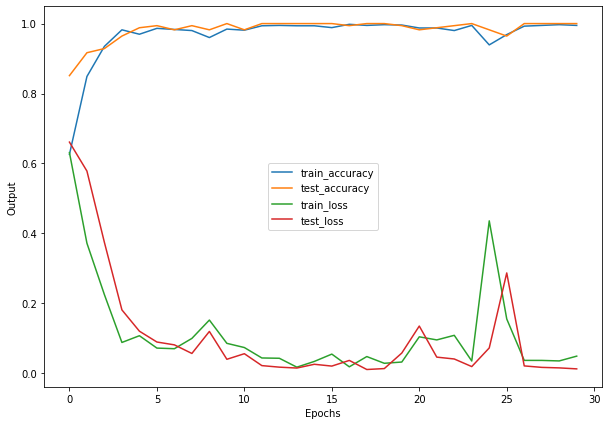

In [38]:
print("*********************Copyright & criminal************")
x=siamese_net1.history.history
plot(x)


*********************Drug/Biotech & Patent************


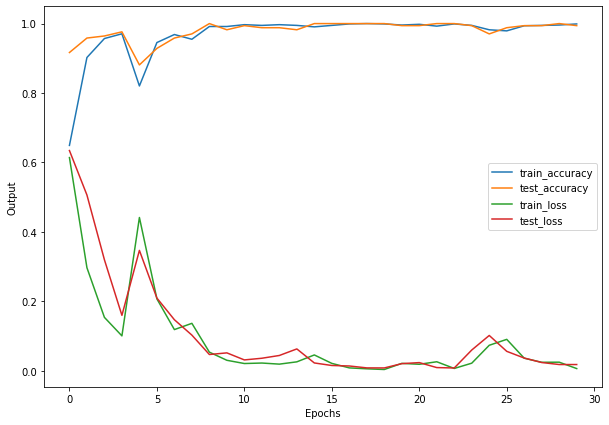

In [39]:
print("*********************Drug/Biotech & Patent************")
x=siamese_net2.history.history
plot(x)

*********************Patent & Employment************


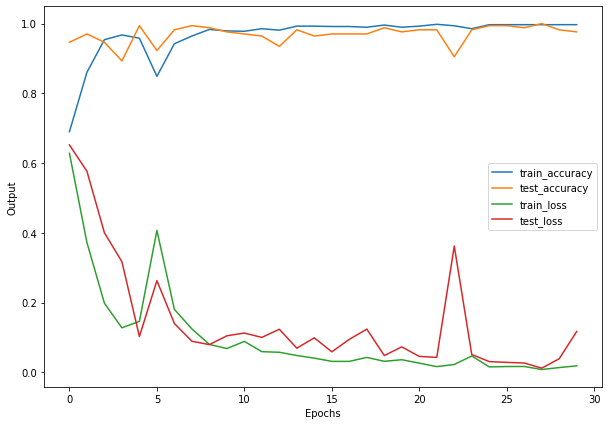

In [40]:
print("*********************Patent & Employment************")
x=siamese_net3.history.history
plot(x)